In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [38]:
file = []
labels = []
for dirname,_, filenames in os.walk('lung_colon_image_set'):
    for filename in filenames:
        if not filename.lower().endswith('.ds_store'):
            if "lung_aca" in dirname:
                labels.append("Lung Adenocarcinoma")
            elif "lung_n" in dirname:
                labels.append("Lung Benign Tissue")
            elif "lung_scc" in dirname:
                labels.append("Lung Squamous Cell Carcinoma")
            elif "colon_n" in dirname:
                labels.append("Colon Benign Tissue")
            elif "colon_aca" in dirname:
                labels.append("Colon Adenocarcinoma")
            file.append(os.path.join(dirname, filename))

In [39]:
Slabels = pd.Series(labels,name="Labels")
Sfile  = pd.Series(file,name="Filepaths")
data = pd.concat([Sfile,Slabels],axis=1)

In [40]:
data.head()

,Filepaths,Labels
0,lung_colon_image_set/lung_image_sets/lung_aca/...,Lung Adenocarcinoma
1,lung_colon_image_set/lung_image_sets/lung_aca/...,Lung Adenocarcinoma
2,lung_colon_image_set/lung_image_sets/lung_aca/...,Lung Adenocarcinoma
3,lung_colon_image_set/lung_image_sets/lung_aca/...,Lung Adenocarcinoma
4,lung_colon_image_set/lung_image_sets/lung_aca/...,Lung Adenocarcinoma


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filepaths  25000 non-null  object
 1   Labels     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [41]:
data.isnull().sum()

Filepaths    0
Labels       0
dtype: int64

In [42]:
data['Labels'].value_counts()

Lung Adenocarcinoma             5000
Lung Benign Tissue              5000
Lung Squamous Cell Carcinoma    5000
Colon Benign Tissue             5000
Colon Adenocarcinoma            5000
Name: Labels, dtype: int64

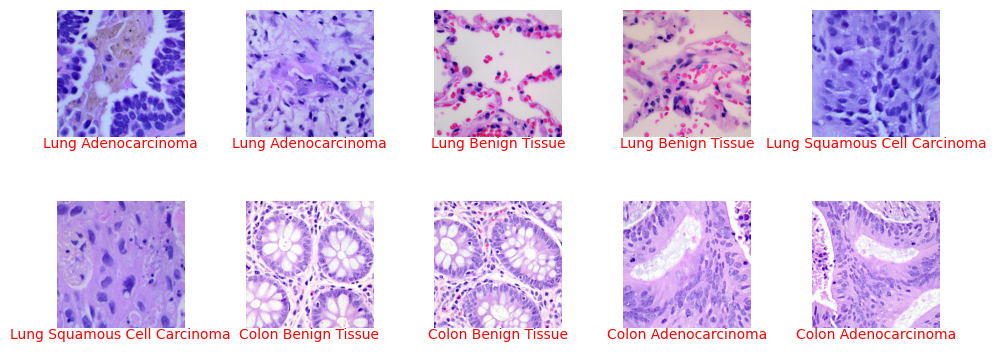

In [43]:
transform = transforms.Compose([transforms.ToTensor()])
grouped = data.groupby('Labels').head(2)

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the groups and plot the images in the subplots
for i, (_, row) in enumerate(grouped.iterrows()):
    # Extract the filepath and label from the row
    filepath = row['Filepaths']
    label = row['Labels']

    # Convert the filepath to a string
    filepath = str(filepath)

    # Open the image file
    image = Image.open(filepath)

    # Apply the transformation to convert the image to a tensor
    tensor = transform(image)

    # Convert the tensor to a numpy array
    array = tensor.numpy()

    # Plot the image in the corresponding subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(array.transpose(1, 2, 0))
    ax.axis('off')
    annotation_x = image.width // 2
    annotation_y = image.height + 1
    # Annotate the image with its label
    ax.annotate(label, (annotation_x, annotation_y), color='red', ha='center', va='top')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
